# Toxic Comment Classification Challenge
Identify and classify toxic online comments

![Toxic Comments](https://storage.googleapis.com/kaggle-media/competitions/jigsaw/003-avatar.png)

Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

The [Conversation AI](https://conversationai.github.io/) team, a research initiative founded by [Jigsaw](https://jigsaw.google.com/) and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). So far they’ve built a range of publicly available models served through the [Perspective API](https://perspectiveapi.com/), including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).

In this competition, you’re challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s [current models](https://github.com/conversationai/unintended-ml-bias-analysis). You’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

_Disclaimer: the dataset for this competition contains text that may be considered profane, vulgar, or offensive._

Dataset Description
-------------------

You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

*   `toxic`
*   `severe_toxic`
*   `obscene`
*   `threat`
*   `insult`
*   `identity_hate`

You must create a model which predicts a probability of each type of toxicity for each comment.

File descriptions
-----------------

*   **train.csv** - the training set, contains comments with their binary labels
*   **test.csv** - the test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.
*   **sample\_submission.csv** - a sample submission file in the correct format
*   **test\_labels.csv** - labels for the test data; value of `-1` indicates it was not used for scoring; (**Note:** file added after competition close!)

Usage
-----

The dataset under [CC0](https://creativecommons.org/share-your-work/public-domain/cc0/), with the underlying comment text being governed by [Wikipedia's CC-SA-3.0](https://creativecommons.org/licenses/by-sa/3.0/)

Link: https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge

In [1]:
import pandas as pd
import numpy as np
from fastai.text.all import *
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
sample_submission_df = pd.read_csv(
    "../../data/jigsaw-toxic-comment-classification-challenge/sample_submission.csv"
).set_index("id")
sample_submission_df

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...
fffcd0960ee309b5,0.5,0.5,0.5,0.5,0.5,0.5
fffd7a9a6eb32c16,0.5,0.5,0.5,0.5,0.5,0.5
fffda9e8d6fafa9e,0.5,0.5,0.5,0.5,0.5,0.5


<IPython.core.display.Javascript object>

In [4]:
test_df = pd.read_csv(
    "../../data/jigsaw-toxic-comment-classification-challenge/test.csv"
).set_index("id")
test_df

,comment_text
id,
00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"
0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO."
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """
00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message."
00017695ad8997eb,I don't anonymously edit articles at all.
...,...
fffcd0960ee309b5,". \n i totally agree, this stuff is nothing but too-long-crap"
fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n Does it get there faster by throwing to cut off man or direct from out fielder? \n Were the out fielders in the Mickey mantle era have better arms? \n Rich
fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I see your changes and agree this is """"more correct."""" I had gotten confused, but then found this: \n :... while acknowledging Japan's territorial rights to Okinotorishima itself ... \n However, is there a category for \n :... did not acknowledge Japan's claim to an exclusive economic zone (EEZ) stemming from Okinotorishima. \n That is, is there a category for """"disputed EEZ""""s? """


<IPython.core.display.Javascript object>

In [5]:
test_labels_df = pd.read_csv(
    "../../data/jigsaw-toxic-comment-classification-challenge/test_labels.csv"
).set_index("id")
test_labels_df

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,-1,-1,-1,-1,-1,-1
0000247867823ef7,-1,-1,-1,-1,-1,-1
00013b17ad220c46,-1,-1,-1,-1,-1,-1
00017563c3f7919a,-1,-1,-1,-1,-1,-1
00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...
fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1


<IPython.core.display.Javascript object>

In [6]:
train_df = pd.read_csv(
    "../../data/jigsaw-toxic-comment-classification-challenge/train.csv"
).set_index("id")
train_df

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_ar...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0
...,...,...,...,...,...,...,...
ffe987279560d7ff,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most significant"""" ones? \n\n""",0,0,0,0,0,0
ffea4adeee384e90,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0,0,0,0,0,0
ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [7]:
train_df[
    ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
].mean()

toxic            0.095844
severe_toxic     0.009996
obscene          0.052948
threat           0.002996
insult           0.049364
identity_hate    0.008805
dtype: float64

<IPython.core.display.Javascript object>

# DataLoader

In [8]:
BATCH_SIZE = 32

<IPython.core.display.Javascript object>

In [9]:
X_train, X_true = train_test_split(train_df, test_size=0.1, random_state=42)
X_train.shape, X_true.shape

((143613, 7), (15958, 7))

<IPython.core.display.Javascript object>

In [10]:
dls = TextDataLoaders.from_df(
    X_train[["comment_text", "toxic"]],
    valid_pct=0.2,
    seed=42,
    bs=BATCH_SIZE,
)

<IPython.core.display.Javascript object>

In [11]:
dls.train.show_batch()

,text,category
0,xxbos xxmaj take that ! \n\n xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass,1
1,xxbos xxup ah xxup haahhahahah y xxrep 3 a xxup bitch y xxrep 4 a ! @ xxrep 6 ! xxup ah xxup haahhahahah y xxrep 3 a xxup bitch y xxrep 4 a ! @ xxrep 6 ! xxup ah xxup haahhahahah y xxrep 3 a xxup bitch y xxrep 4 a ! @ xxrep 6 ! xxup ah xxup haahhahahah y xxrep 3 a xxup bitch y xxrep 4 a ! @ xxrep 6 ! xxup ah xxup haahhahahah y xxrep 3 a xxup bitch y xxrep 4 a ! @ xxrep 6 ! xxup ah xxup haahhahahah y xxrep 3 a xxup bitch y xxrep 4 a ! @ xxrep 6 ! xxup ah xxup haahhahahah y xxrep 3 a xxup bitch y xxrep 4 a ! @ xxrep 6 ! xxup ah xxup haahhahahah y xxrep 3 a xxup bitch y xxrep 4 a ! @,1
2,xxbos xxup jim xxup wales xxup must xxup die xxrep 12 ! xxup jim xxup wales xxup must xxup die xxrep 12 ! xxup jim xxup wales xxup must xxup die xxrep 12 ! xxup jim xxup wales xxup must xxup die xxrep 12 ! xxup jim xxup wales xxup must xxup die xxrep 12 ! xxup jim xxup wales xxup must xxup die xxrep 12 ! xxup jim xxup wales xxup must xxup die xxrep 12 ! xxup jim xxup wales xxup must xxup die xxrep 12 ! xxup jim xxup wales xxup must xxup die xxrep 12 ! xxup jim xxup wales xxup must xxup die xxrep 12 ! xxup jim xxup wales xxup must xxup die xxrep 12 ! xxup jim xxup wales xxup must xxup die xxrep 12 ! xxup jim xxup wales xxup must xxup die xxrep 12 ! xxup jim xxup wales xxup must,1
3,xxbos xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010 xxup is a xxup nigger xxup tommy2010,1
4,"xxbos "" \n\n▁ xxrep 4 _ \n\n xxmaj well all right , at least we are getting some debate on the subject . \n\n xxmaj paul xxmaj siebert - xxmaj the main contribution of the xxup xxunk 36 was the sloped armor on all sides , with the slope of the hull continuous with the turret , so that the tank ended up with a pyramidal shape and a very small turret . xxmaj this was exactly the same shape of the xxup t-34 which appeared some 3 - 4 years later than the xxup xxunk 36 and yet the xxup t-34 gets all the credit and accolades as a "" "" revolutionary design "" "" for its sloped armor . xxmaj well , the xxmaj french came up with that idea first ( p. 247 - 248 in xxup t-34 xxmaj mythical xxmaj weapon ) . xxmaj michulec goes",0
5,"xxbos "" \n\n death to critics \n\n xxmaj so instead of ' every ' earlier , now you are giving isolated cases , such as xxmaj theo van xxmaj gogh , xxmaj vincent van xxmaj gogh , xxmaj rashad xxmaj khalifa , and xxmaj xxunk xxmaj xxunk who received death threats or were killed by anonymous unknown radicals . xxmaj what happened to every claim ? xxmaj anyway , to prove your case that xxmaj islam sanctions death sentence to its critics , you ca n't just post the names of isolated cases where people receive

<IPython.core.display.Javascript object>

# Train

In [12]:
# https://docs.fast.ai/tutorial.text.html
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn

<IPython.core.display.Javascript object>

SuggestedLRs(valley=0.007585775572806597)

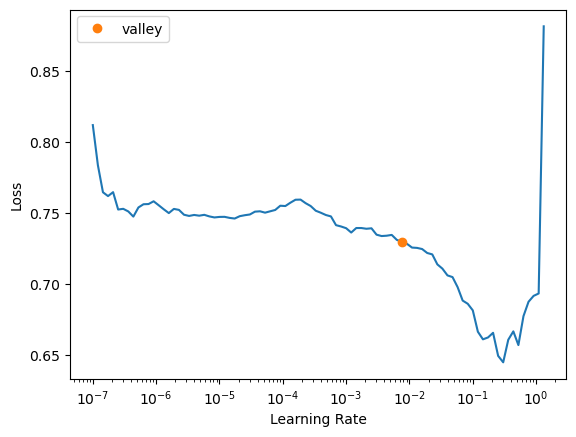

<IPython.core.display.Javascript object>

In [13]:
learn.lr_find()

In [14]:
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.215169,0.180435,0.930854,02:58


epoch,train_loss,valid_loss,accuracy,time
0,0.121261,0.119856,0.954878,06:35
1,0.101179,0.117085,0.953833,06:34
2,0.082559,0.092573,0.965114,06:36
3,0.072075,0.094215,0.964383,06:33


<IPython.core.display.Javascript object>

In [15]:
learn.show_results()

,text,category,category_
0,xxbos xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup die xxup fag xxup,1,1
1,xxbos { { unblock| xxmaj oxymoron is a moron in an xxmaj oxymoron xxmaj oxymoron is a moron in an xxmaj oxymoron xxmaj oxymoron is a moron in an xxmaj oxymoron xxmaj oxymoron is a moron in an xxmaj oxymoron xxmaj oxymoron is a moron in an xxmaj oxymoron xxmaj oxymoron is a moron in an xxmaj oxymoron xxmaj oxymoron is a moron in an xxmaj oxymoron xxmaj oxymoron is a moron in an xxmaj oxymoron xxmaj oxymoron is a moron in an xxmaj oxymoron xxmaj oxymoron is a moron in an xxmaj oxymoron xxmaj oxymoron is a moron in an xxmaj oxymoron xxmaj oxymoron is a moron in an xxmaj oxymoron xxmaj oxymoron is a moron in an xxmaj oxymoron xxmaj oxymoron is a moron in an xxmaj oxymoron xxmaj oxymoron is a moron in an xxmaj oxymoron xxmaj oxymoron is a moron in an xxmaj oxymoron xxmaj oxymoron,1,0
2,"xxbos "" \n\n xxmaj second tranche of comments \n xxmaj managing career \n "" "" the xxmaj browns released him "" "" - since it 's the first mention in the section , change "" "" him "" "" to \n "" "" he managed to recover from his injury "" "" - changed to \n "" "" a couple of seasons "" "" - how many is a couple ? xxmaj be specific . \n "" "" for the xxmaj bridgeport , xxmaj connecticut club for the xxmaj eastern xxmaj league "" "" - would be more concise \n "" "" june 27 , 1918 "" "" - comma after year \n "" "" players in the xxmaj bronx "" "" - de - link , used barely half a screen earlier \n "" "" and move back to baseball as a career "" "" - would be more",0,0
3,"xxbos "" own books . xxmaj moreover , those books do n't appear to have any independent notability per xxup wp : n and xxup wp : v. nawlinwiki ( talk ) "" "" . xxmaj please respond in much more detailed and sensible argument and valid reasons to the two detailed replies to you , as to why you , with such hast and vigour , tagged for speedy deletion the article of the seven volumes of xxmaj triumph of xxmaj truth ( who s xxmaj watching xxmaj the xxmaj watchers ? ) . xxmaj please be kind enough to also provide your reply on your own talk page ( this page , http : / / en.wikipedia.org / w / xxunk ) and please also explain why , when i was editing the original article in the sandbox section , the drafts that i worked hard on ,",0,0
4,xxbos xxup you xxup are a xxup mothjer xxup fucker xxup cocksucker ! xxup you xxup are a xxup mothjer xxup fucker xxup xxunk xxup are a xxup mothjer xxup fucker xxup cocksucker ! xxup you xxup are a xxup mothjer xxup fucker xxup cocksucker ! xxup you xxup are a xxup mothjer xxup fucker xxup cocksucker ! xxup you xxup are a xxup mothjer xxup fucker xxup cocksucker ! xxup you xxup are a xxup mothjer xxup fucker xxup cocksucker ! xxup you xxup are a xxup mothjer xxup fucker xxup cocksucker ! xxup you xxup are a xxup mothjer xxup fucker xxup cocksucker ! xxup you xxup are a xxup mothjer xxup fucker xxup cocksucker ! xxup you xxup are a xxup mothjer xxup fucker xxup cocksucker ! xxup you xxup are a xxup mothjer xxup fucker xxup cocksucker ! xxup you xxup are a xxup mothjer xxup,1,1
5,"xxbos "" \n\n▁ xxmaj neautrality and xxmaj balance . \n\n xxmaj article is strong anti - nop ( which is against of xxup npov ) . xxmaj it does n't fit any of xxmaj wikipedia 's xxup npov points . xxmaj step by step \n\n xxmaj views \n xxmaj the manifesto of the xxmaj national xxmaj reviv

<IPython.core.display.Javascript object>

In [16]:
learn.save("toxic-baseline")

Path('models/toxic-baseline.pth')

<IPython.core.display.Javascript object>

# Validate

In [30]:
tqdm.pandas()

preds = X_true[["toxic"]].copy()

# https://github.com/fastai/fastai/issues/3366#issuecomment-838523767
with learn.no_bar(), learn.no_logging():
    preds["pred"] = X_true["comment_text"].progress_map(
        lambda x: int(learn.predict(x)[0])
    )

preds

  0%|          | 0/15958 [00:00<?, ?it/s]

,toxic,pred
id,,
7ca72b5b9c688e9e,0,0
c03f72fd8f8bf54f,0,0
9e5b8e8fc1ff2e84,0,0
5332799e706665a6,0,0
dfa7d8f0b4366680,0,0
...,...,...
866d4e0825db6c28,0,0
9d9a990822eeb1cd,0,0
fc1fb5d80448447d,0,0


<IPython.core.display.Javascript object>

In [31]:
(preds["toxic"] == preds["pred"]).sum() / len(preds)

0.965659857124953

<IPython.core.display.Javascript object>